Необходимо провести анализ и построить модель, которая будет предсказывать объём списания на 12 месяцев вперед (помесячно).
Оценить точность модели. 
Описание набора данных:

sintez_group - наименование синтез-группы  
posting_date - дата  
inc_bmu_fact_count - кол-во приходов в день posting_date  
inc_bmu_sum - сумма приходов в день  
out_bmu_fact_count - кол-во списаний в день  
out_bmu_sum - сумма списаний в день  
stock_sum - уровень запасов на текущий день  
 

In [ ]:
import pandas as pd
from pandas import read_parquet
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import numpy as np

Рассмотрим данные

In [20]:
gaz_data = read_parquet('C:/Users/User.DESKTOP-DG6H515/Desktop/Задание для кандидатов DS/zra_4_150_40_ts.parquet')
gaz_data

sintez_group posting_date  inc_bmu_fact_count  inc_bmu_sum  \
0     ЗРА_4_150_40   2017-01-01                   0          0.0   
1     ЗРА_4_150_40   2017-01-02                   0          0.0   
2     ЗРА_4_150_40   2017-01-03                   0          0.0   
3     ЗРА_4_150_40   2017-01-04                   0          0.0   
4     ЗРА_4_150_40   2017-01-05                   0          0.0   
...            ...          ...                 ...          ...   
2029  ЗРА_4_150_40   2022-07-23                   0          0.0   
2030  ЗРА_4_150_40   2022-07-24                   0          0.0   
2031  ЗРА_4_150_40   2022-07-25                   0          0.0   
2032  ЗРА_4_150_40   2022-07-26                   0          0.0   
2033  ЗРА_4_150_40   2022-07-27                   0          0.0   

      out_bmu_fact_count  out_bmu_sum  stock_sum  
0                      0          0.0      507.0  
1                      0          0.0      507.0  
2                      0          0.0      507.0  
3                      0          0.0      505.0  
4                      0          0.0      505.0  
...                  ...          ...        ...  
2029                   0          0.0      485.0  
2030                   0          0.0      485.0  
2031                   0          0.0      485.0  
2032                   0          0.0      485.0  
2033                   0          0.0      485.0  

[2034 rows x 7 columns]

Создадим переменную объем, как количесвто списаний*сумму списаний в день

In [21]:
gaz_data["volume"] = gaz_data["out_bmu_fact_count"]*gaz_data["out_bmu_sum"]

In [863]:
gaz_data['posting_month'] = pd.to_datetime(gaz_data['posting_date']).dt.to_period('M')

Сагрегируем данные по месяцам

In [864]:
gaz_data_sum = gaz_data.groupby(['posting_month']).sum().reset_index()
gaz_data_sum

posting_month  inc_bmu_fact_count  inc_bmu_sum  out_bmu_fact_count  \
0        2017-01                   7         27.0                  20   
1        2017-02                   6         19.0                  25   
2        2017-03                  25         96.0                  71   
3        2017-04                  45        147.0                  62   
4        2017-05                  27        224.0                  50   
..           ...                 ...          ...                 ...   
62       2022-03                  14         34.0                  23   
63       2022-04                  18         42.0                  21   
64       2022-05                   2         10.0                  31   
65       2022-06                   1          3.0                   1   
66       2022-07                   0          0.0                   0   

    out_bmu_sum  stock_sum  volume  
0          21.0    15645.0   103.0  
1          28.0    14568.0   142.0  
2          76.0    16785.0   651.0  
3          78.0    17874.0  1490.0  
4          76.0    22085.0  1121.0  
..          ...        ...     ...  
62         33.0    16120.0   177.0  
63         34.0    15606.0   122.0  
64         47.0    16248.0   248.0  
65          2.0    14614.0     2.0  
66          0.0    13095.0     0.0  

[67 rows x 7 columns]

In [865]:
gaz_data_sum['posting_month'] = gaz_data_sum['posting_month'].astype('str')

Посмотрим, как распределена целевая переменная во времени

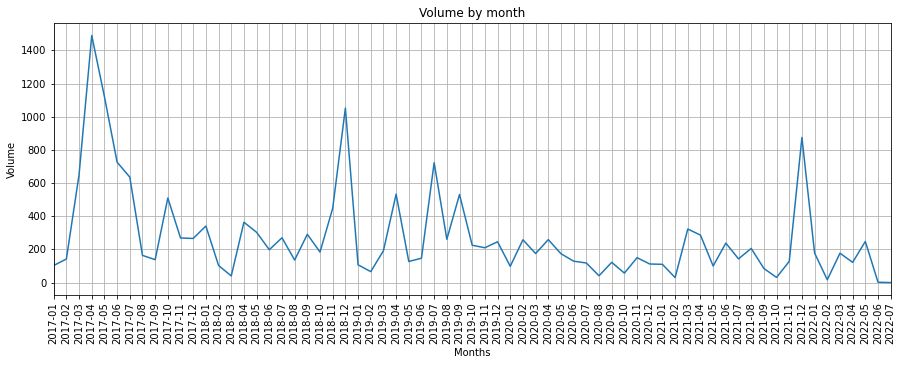

In [804]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Volume by month')
plt.ylabel('Volume')
plt.xlabel('Months')
plt.grid(True)
plt.xticks(rotation=90)
plt.autoscale(axis='x', tight=True)
plt.plot(gaz_data_sum['posting_month'], gaz_data_sum['volume'])
plt.show()

### Для прогноза используем модель lstm для предсказания временного ряда

In [32]:
import torch
import torch.nn as nn

In [545]:
warnings.filterwarnings('ignore')


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

Размер тестовой выборки определим в год, так как предсказывать необходимо также на год вперед

In [642]:
test_data_size = len(gaz_data_sum) - int(len(gaz_data_sum) * 5 / 6)

all_data = gaz_data_sum.volume.values

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

In [643]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

print(train_inout_seq[:5])

[(tensor([-0.9000, -0.8466, -0.1493,  1.0000,  0.4945, -0.0466, -0.1699, -0.8164,
        -0.8521, -0.3425, -0.6726, -0.6767]), tensor([-0.5740])), (tensor([-0.8466, -0.1493,  1.0000,  0.4945, -0.0466, -0.1699, -0.8164, -0.8521,
        -0.3425, -0.6726, -0.6767, -0.5740]), tensor([-0.9000])), (tensor([-0.1493,  1.0000,  0.4945, -0.0466, -0.1699, -0.8164, -0.8521, -0.3425,
        -0.6726, -0.6767, -0.5740, -0.9000]), tensor([-0.9863])), (tensor([ 1.0000,  0.4945, -0.0466, -0.1699, -0.8164, -0.8521, -0.3425, -0.6726,
        -0.6767, -0.5740, -0.9000, -0.9863]), tensor([-0.5425])), (tensor([ 0.4945, -0.0466, -0.1699, -0.8164, -0.8521, -0.3425, -0.6726, -0.6767,
        -0.5740, -0.9000, -0.9863, -0.5425]), tensor([-0.6260]))]


In [784]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,betas=(0.9,0.999),eps=1e-08)

print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [792]:
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00037824
epoch:  25 loss: 0.00005257
epoch:  50 loss: 0.00013313
epoch:  75 loss: 0.00065758
epoch: 100 loss: 0.00004542
epoch: 125 loss: 0.00798332
epoch: 150 loss: 0.00000366
epoch: 175 loss: 0.00000212
epoch: 199 loss: 0.0000291639


In [793]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.9849315285682678, -0.8739725947380066, -0.9630137085914612, -0.835616409778595, -0.8876712322235107, -0.8904109597206116, -1.0, -0.5986301302909851, -0.6493150591850281, -0.9041095972061157, -0.715068519115448, -0.8452054858207703]


In [794]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
#print(actual_predictions)

In [796]:
mean_squared_error(test_data, actual_predictions)

40206.20873221089

In [797]:
mean_absolute_error(test_data, actual_predictions)

172.07711792488888

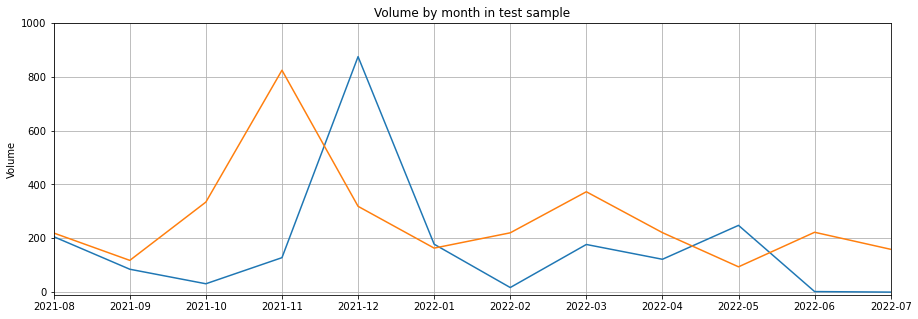

In [868]:
plt.title('Volume by month in test sample')
plt.ylabel('Volume')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(gaz_data_sum['posting_month'][-train_window:], gaz_data_sum['volume'][-train_window:])
plt.plot(gaz_data_sum['posting_month'][-train_window:].values,actual_predictions[:12])
plt.ylim(-10,1000)
plt.show()

В среднем, модель ошибается на 170 условных единиц, но научилась определять локальный максимум volume на тестовом отрезке времени

### Предсказание на 12 месяцев вперед

In [816]:
fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
#print(actual_predictions)

[-0.9849315285682678, -0.8739725947380066, -0.9630137085914612, -0.835616409778595, -0.8876712322235107, -0.8904109597206116, -1.0, -0.5986301302909851, -0.6493150591850281, -0.9041095972061157, -0.715068519115448, -0.8452054858207703]


In [847]:
future = pd.date_range(start='8/1/2021', periods=24, freq='M',)
future = [str(t)[0:7] for t in future]

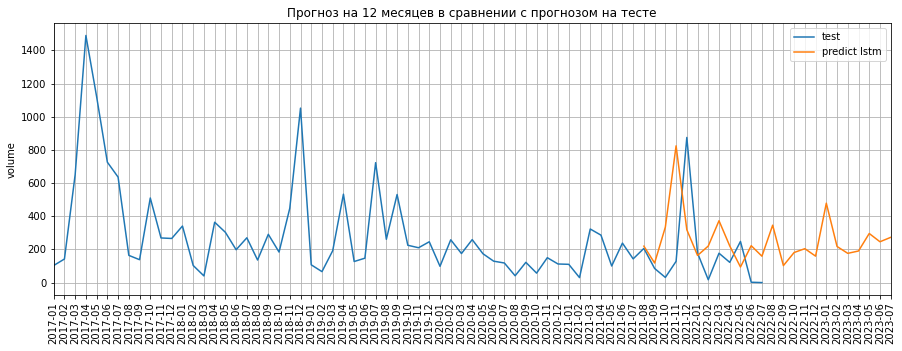

In [861]:
x = np.arange(55, 79, 1)

plt.title('Прогноз на 12 месяцев в сравнении с прогнозом на тесте')
plt.ylabel('volume')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(gaz_data_sum['posting_month'], gaz_data_sum['volume'], label='test')
plt.plot(future, actual_predictions, label='predict lstm')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Прогноз на 12 месяцев:

In [859]:
pd.DataFrame({'date':future[12:],'volume':actual_predictions[12:].reshape(1,-1)[0]})

date      volume
0   2022-08  346.014311
1   2022-09  102.375368
2   2022-10  181.310948
3   2022-11  204.413495
4   2022-12  159.347965
5   2023-01  478.733277
6   2023-02  217.626425
7   2023-03  176.227686
8   2023-04  190.469574
9   2023-05  295.908290
10  2023-06  246.088270
11  2023-07  272.683737

### Заключение:

Модель lstm в среднем ошибается на 170 условных единиц, и научилсась определять пиковые значения Volume на определенном отрезке. Возможно, стоит подобрать параметры для обучения, тогда прогноз будет более точным